# Importing the required libraries which we will be using in the course of this implementation

In [7]:
import numpy as np
import pandas as pd
import os,pathlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

# A sample image in the CelebA Dataset

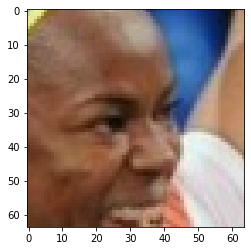

In [8]:
path='/content/drive/MyDrive/celeba'+'/161979.jpg'
img=cv2.imread(path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [9]:
print(img.shape) #To show the size of the image
print(type(img)) #Data type of the image

(64, 64, 3)
<class 'numpy.ndarray'>


##Creating our dataset

In [4]:
#24396 images in the celeba dataset

## Reading in 5,000 images for the purposes of training and testing

In [10]:
path_d='/content/drive/MyDrive/celeba'
ct=161979
X = np.zeros((5000,64 , 64, 3), dtype=np.float32) #Creating a numpy array for 5,000 RGB Images
for path in pathlib.Path(path_d).iterdir(): #Iterating over the directory of images
  img = cv2.imread(str(path)) #Reading in this images
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting the image from BGR format (i.e the default format it is read in), to RGB
  img = img.astype('float32') #Setting the datatype as a 32 bit float value
  X[ct-161979]=img/255 #Normalizing images for avoiding the problem of exploding gradients and improving convergence speed
  if (ct-161979)==4999:
    break
  ct+=1

##Encoder

In [14]:
input_img = layers.Input(shape=(64, 64, 3)) #Creating our encoder network
x = layers.Conv2D(128,kernel_size=5, strides=2, padding='same',activation='relu')(input_img) #Downsampling the image using a 128 unit Conv2D layer
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x) #Downsampling the image using a 256 unit Conv2D layer
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)  #Downsampling the image using a 128 unit Conv2D layer
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x) #Flattening the image and then, converting it into a dense 4608 length vector, 4608=3*3*512
x = layers.Dense(4608)(x)
encoded = layers.Reshape((3,3,512))(x) # Reshaping the image into this format for implementing the process of Upsampling
encoder = keras.Model(input_img, encoded,name="encoder")

##Decoder

In [15]:
decoder_input= layers.Input(shape=((3,3,512))) #Reading the earlier input from the encoder
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(decoder_input) #Upsampling the image starting with a 512 unit Conv2D layer
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x) #Upsampling the image using a 256 unit Conv2D layer
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128,kernel_size=5, strides=2, padding='same',activation='relu')(x) #Upsampling the image using a 128 unit Conv2D layer
x = layers.Flatten()(x)
x = layers.Dense(np.prod((64, 64, 3)))(x) #Flattening the image and then, converting it into a (64,64,3) image output
decoded = layers.Reshape((64, 64, 3))(x)
decoder = keras.Model(decoder_input, decoded,name="decoder")

## Creating the encoder and decoder (combined) model

In [16]:
auto_input = layers.Input(shape=(64,64,3)) 
encoded = encoder(auto_input)
decoded = decoder(encoded)
 
autoencoder = keras.Model(auto_input, decoded,name="autoencoder")
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-5, beta_1=0.5, beta_2=0.999), loss='mae')
# loss used here is 'mean absolute error'
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 3, 3, 512)         6470400   
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         16954240  
                                                                 
Total params: 23,424,640
Trainable params: 23,424,640
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


##Train-test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,X, test_size=0.20, random_state=0) #Doing an 80-20 split

##Training the model

Training the model for 1,000 epochs with a batch size of 128 and saving the model with the least validation loss.

In [18]:
checkpoint1 = ModelCheckpoint("autoencoder_celeba.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history1 = autoencoder.fit(X_train, X_train, epochs=1000, batch_size=128, shuffle=True, validation_data=(X_test, X_test), callbacks=[checkpoint1])

Epoch 1/1000
32/32 [==============================] - ETA: 0s - loss: 0.3384
Epoch 00001: val_loss improved from inf to 0.16625, saving model to autoencoder_celeba.hdf5
32/32 [==============================] - 20s 93ms/step - loss: 0.3384 - val_loss: 0.1662
Epoch 2/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1575
Epoch 00002: val_loss improved from 0.16625 to 0.15499, saving model to autoencoder_celeba.hdf5
32/32 [==============================] - 2s 72ms/step - loss: 0.1575 - val_loss: 0.1550
Epoch 3/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1557
Epoch 00003: val_loss improved from 0.15499 to 0.15435, saving model to autoencoder_celeba.hdf5
32/32 [==============================] - 3s 93ms/step - loss: 0.1559 - val_loss: 0.1543
Epoch 4/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1547
Epoch 00004: val_loss improved from 0.15435 to 0.15387, saving model to autoencoder_celeba.hdf5
32/32 [==============================] - 3s 89m

##Viewing the outputs to the code

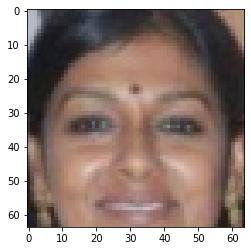

In [39]:
%matplotlib inline
plt.figure()
plt.imshow(X_test[6]) # A sample image in the test set
plt.show()

## The predicted/ deepfake image of this image from the test set

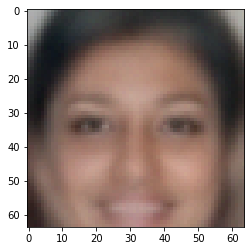

In [38]:
output_image = autoencoder.predict(np.array([X_test[6]]))
plt.figure()
plt.imshow(output_image[0])
plt.show()

## Loading the model with the least validation loss

In [40]:
from keras.models import load_model
import numpy as np
model_n = load_model('/content/autoencoder_celeba.hdf5')

## Testing the 'least validation loss' model.

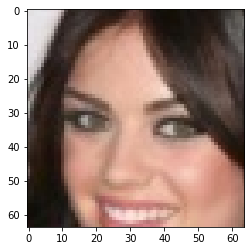

In [49]:
%matplotlib inline
plt.figure()
plt.imshow(X_test[70])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


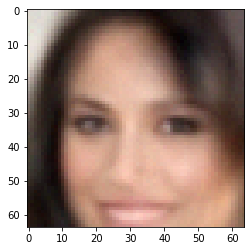

In [48]:
output_image = model_n.predict(np.array([X_test[70]]))
plt.figure()
plt.imshow(output_image[0])
plt.show()

## Finally, the loss metrics

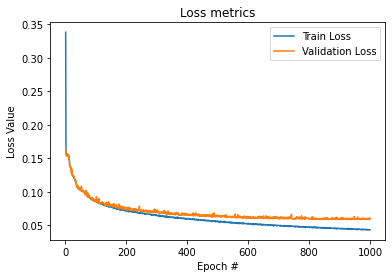

In [71]:
fig = plt.figure()
#t = fig.set_title('Autoencoder for Deepfake Image prediction metrics', fontsize=12)
EPOCHS=1000
epoch_list = list(range(1,EPOCHS+1))
ax2 = fig.add_subplot(111)
ax2.plot(epoch_list, history1.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history1.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss metrics', fontsize=12)
l2 = ax2.legend(loc="best")